## 03

In [3]:
import laspy
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from statistics import fmean
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [1]:
def compute_variance_for_point(i, neighbors, xyz):
    indices = neighbors.radius_neighbors(xyz[i:i+1], return_distance=False)[0]
    if len(indices) > 1:
        return np.var(xyz[indices, 2])
    return 0
    
def load_las_features_labels(file_path, max_samples_per_class):
    las = laspy.read(file_path)
    
    xyz = np.vstack((las.X * las.header.scale[0] + las.header.offset[0],
                     las.Y * las.header.scale[1] + las.header.offset[1],
                     las.Z * las.header.scale[2] + las.header.offset[2])).T

    intensity = las.intensity
    classification = las.classification

    mask = ~np.isin(classification, [0, 7, 9])
    xyz = xyz[mask]
    intensity = intensity[mask]
    classification = classification[mask]
    
    if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
        red = las.red[mask].astype(np.float32) / 65535
        green = las.green[mask].astype(np.float32) / 65535
        blue = las.blue[mask].astype(np.float32) / 65535
    else:
        red = np.zeros(len(xyz), dtype=np.float32)
        green = np.zeros(len(xyz), dtype=np.float32)
        blue = np.zeros(len(xyz), dtype=np.float32)

    if max_samples_per_class:
        class_counts = Counter(classification)
        selected_indices = []

        for cls, count in class_counts.items():
            cls_indices = np.where(classification == cls)[0]
            if count > max_samples_per_class:
                cls_indices = np.random.choice(cls_indices, max_samples_per_class, replace=False)
            selected_indices.extend(cls_indices)

        xyz = xyz[selected_indices]
        intensity = intensity[selected_indices]
        classification = classification[selected_indices]
        red = red[selected_indices]
        green = green[selected_indices]
        blue = blue[selected_indices]

    min_z = np.min(xyz[:, 2])
    height_above_ground = xyz[:, 2] - min_z

    neighbors = NearestNeighbors(radius=1, algorithm='kd_tree').fit(xyz)
    local_density = neighbors.radius_neighbors_graph(xyz).sum(axis=1).A1
    
    local_variance = Parallel(n_jobs=12)(
        delayed(compute_variance_for_point)(i, neighbors, xyz) for i in range(len(xyz))
    )
    local_variance = np.array(local_variance, dtype=np.float32)
    
    features = np.column_stack((intensity, height_above_ground, red, green, blue))
    return features, classification

In [5]:
def plot_confusion_matrix(eval_labels, predicted_labels):
    class_labels = [2, 3, 4, 5, 6]
    
    conf_matrix = confusion_matrix(eval_labels, predicted_labels, labels=class_labels)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Raw confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(eval_labels), yticklabels=np.unique(eval_labels), ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted Class")
    axes[0].set_ylabel("True Class")
    
    # Normalized confusion matrix
    sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap='Oranges', xticklabels=np.unique(eval_labels), yticklabels=np.unique(eval_labels), ax=axes[1])
    axes[1].set_title("Normalized Confusion Matrix (%)")
    axes[1].set_xlabel("Predicted Class")
    axes[1].set_ylabel("True Class")
    
    plt.tight_layout()
    plt.show()

In [7]:
def load_clouds_features(file_paths, max_samples):
    max_samples_per_class = int(max_samples / (len(file_paths) - 1))
    clouds = []
    for file in file_paths:
        features, labels = load_las_features_labels(file, max_samples_per_class)
        clouds.append( (features, labels) )
    return clouds

def merge_features(clouds_features):
    features = []
    labels = []
    for cloud in clouds_features:
        features.append(cloud[0])
        labels.append(cloud[1])
    features_merged = np.vstack(features)
    labels_merged = np.concatenate(labels)
    return features_merged, labels_merged

def mean_iou(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    IoUs = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm) + 1e-7)
    return np.nanmean(IoUs)
    
def cross_eval(clouds_features):
    acc = []
    mious = []
    all_eval_labels = []
    all_pred_labels = []
    
    for i, cloud in enumerate(clouds_features):
        print(f"Konfiguracja {i}")
        eval_features, eval_labels = cloud 
        train_clouds = clouds_features[:i] + clouds_features[i+1:] 

        train_features, train_labels = merge_features(train_clouds)

        unique, counts = np.unique(train_labels, return_counts=True)
        print(f"Liczność klas przed oversamplingiem:")
        print({cls: count for cls, count in zip(unique, counts)})
        
        smote = SMOTE(sampling_strategy='auto', random_state=7)
        train_features, train_labels = smote.fit_resample(train_features, train_labels)

        unique, counts = np.unique(train_labels, return_counts=True)
        print(f"Liczność klas po oversamplingu:")
        print({cls: count for cls, count in zip(unique, counts)})
        
        clf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=12, class_weight="balanced")
        clf.fit(train_features, train_labels)

        predicted_labels = clf.predict(eval_features)
        print(f"Classification Report {i}")
        print(classification_report(eval_labels, predicted_labels, zero_division=0))
        acc.append(accuracy_score(eval_labels, predicted_labels))
        mious.append(mean_iou(eval_labels, predicted_labels, 5))
        all_eval_labels += list(eval_labels)
        all_pred_labels += list(predicted_labels)
    oa = fmean(acc)
    miou = fmean(mious)
    print("SUMMARY")
    print(f"OA: {oa}")
    print(f"mIoU: {miou}")
    plot_confusion_matrix(all_eval_labels, all_pred_labels)
        

Konfiguracja 0
Liczność klas przed oversamplingiem:
{2: 999999, 3: 892238, 4: 393667, 5: 930265, 6: 999999}
Liczność klas po oversamplingu:
{2: 999999, 3: 999999, 4: 999999, 5: 999999, 6: 999999}
Classification Report 0
              precision    recall  f1-score   support

           2       0.70      0.65      0.67    333333
           3       0.29      0.29      0.29    124877
           4       0.25      0.26      0.26     77354
           5       0.87      0.83      0.85    333333
           6       0.79      0.87      0.83    333333

    accuracy                           0.70   1202230
   macro avg       0.58      0.58      0.58   1202230
weighted avg       0.70      0.70      0.70   1202230

Konfiguracja 1
Liczność klas przed oversamplingiem:
{2: 999999, 3: 791543, 4: 393508, 5: 999999, 6: 999999}
Liczność klas po oversamplingu:
{2: 999999, 3: 999999, 4: 999999, 5: 999999, 6: 999999}
Classification Report 1
              precision    recall  f1-score   support

           2    

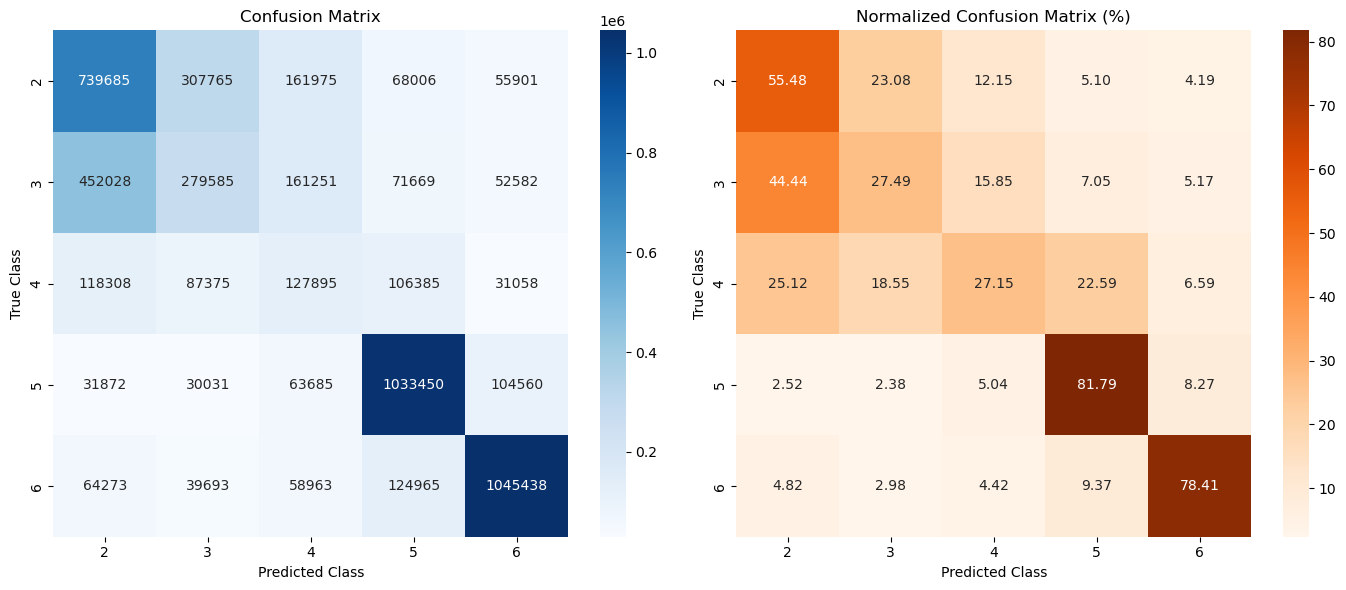

Time: 877.1713902950287


In [9]:
time_start = time.time()

file_paths = ["LAS/N-34-50-C-d-3-3-2-2.las", "LAS/N-34-50-C-d-3-3-2-4.las", "LAS/N-34-50-C-c-4-2-2-2.las", "LAS/N-34-50-C-c-4-2-2-1.las"]

clouds = load_clouds_features(file_paths, 1000000)

cross_eval(clouds)

print(f'Time: {time.time() - time_start}')

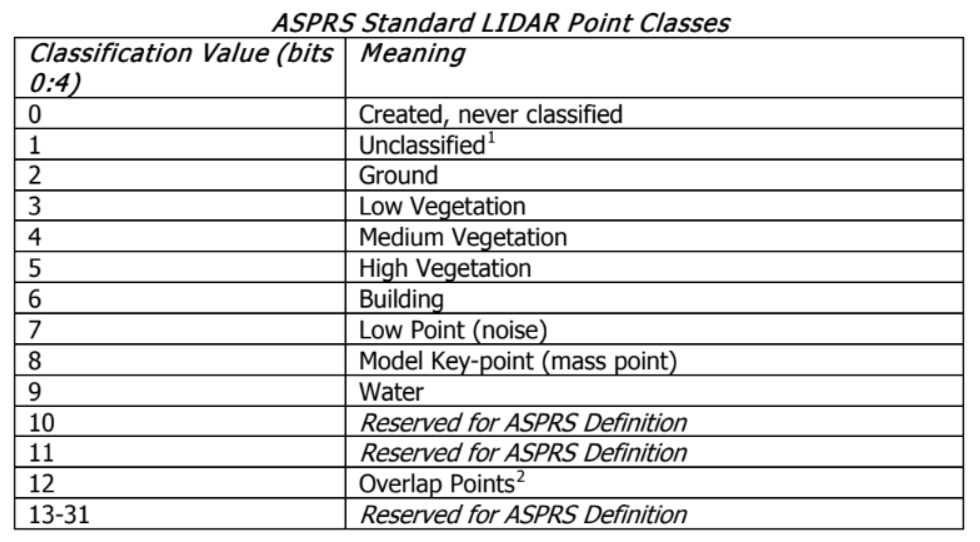

In [29]:
import laspy
def create_new_las(old_path, new_path):
    las_new = laspy.read(old_path)
    
    mask = ~np.isin(las_new.classification, [0, 7, 9])
    
    new_classification = las_new.classification.copy()
    new_classification[mask] = y_pred
    
    las_new.classification = new_classification
    
    las_new.write(new_path)
    print(f"Zapisano plik jako {new_path}")



In [33]:
create_new_las(file_paths[3], "LAS_OUT/01.las")

Zapisano plik jako LAS_OUT/01.las
